# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [17]:
df_offers = pd.read_excel("/Users/shivanginimarjiwe/Desktop/repo/DataScienceGuidedCapstone/1602764303_Clustering_Case_Study_updated_10_15_2020/WineKMC.xlsx")

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [19]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [25]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [29]:
# Display the actual column names of df_offers
df_offers.columns


Index(['offer_id', 'campaign', 'varietal', 'min_qty', 'discount', 'origin',
       'past_peak'],
      dtype='object')

In [33]:
#your turn
# Merge df_transactions with df_offers on "offer_id" to include offer details
merged_df = pd.merge(df_transactions, df_offers, left_on="offer_id", right_on="offer_id")

# Create a pivot table where each row is a customer, and each column is an offer (0/1 indicator)
pivoted_df = merged_df.pivot_table(index='customer_name', 
                                   columns='offer_id', 
                                   values='n', 
                                   fill_value=0)

# Rename columns for clarity
pivoted_df.columns = [f"offer_{col}" for col in pivoted_df.columns]

# Display the transformed dataset
display(pivoted_df)


,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,offer_10,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

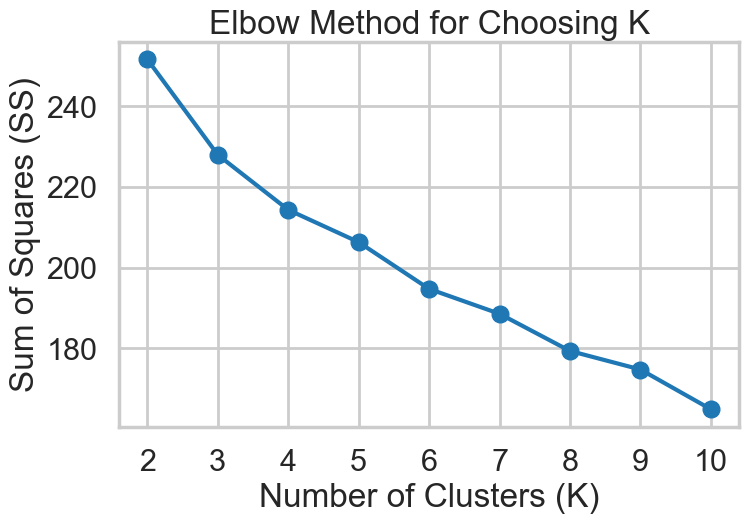

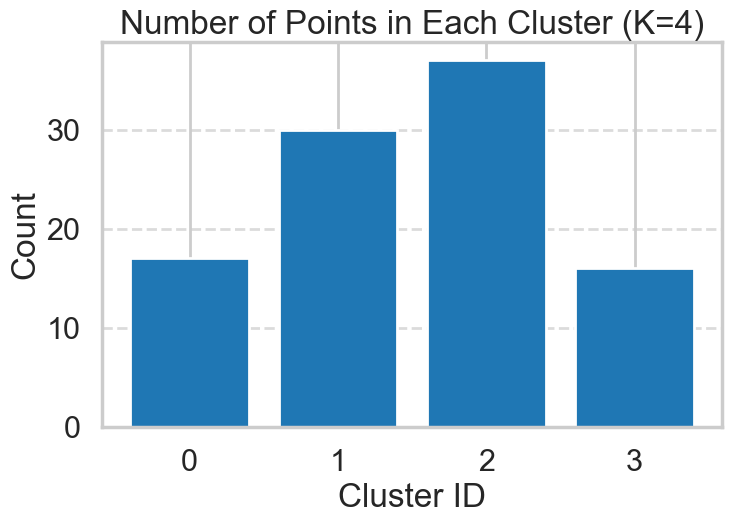

In [35]:
# your turn

import numpy as np
from sklearn.cluster import KMeans

# Convert the pivoted dataframe to a NumPy matrix
X = pivoted_df.to_numpy()

# Define range for K values (2 to 10 as per the instruction)
Krange = list(range(2, 11))

# Initialize empty lists for Sum of Squares (SS) and cluster assignments
ss = []
assignments = {}

# Iterate through K values to compute sum of squared errors (SS)
for K in Krange:
    model = KMeans(n_clusters=K, random_state=42, n_init=10)
    assigned_cluster = model.fit_predict(X)
    ss.append(model.inertia_)  # Inertia is the sum of squared distances to centroids
    assignments[str(K)] = assigned_cluster

# Plot Sum of Squares (SS) for each K
plt.figure(figsize=(8, 5))
plt.plot(Krange, ss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squares (SS)")
plt.title("Elbow Method for Choosing K")
plt.xticks(Krange)
plt.grid(True)
plt.show()

# Determine the best K (visually choosing from the Elbow Method)
best_K = 4  # This can be adjusted based on the plot

# Get the cluster assignments for the best K
assignments_best_K = assignments[str(best_K)]

# Count the number of points in each cluster
counts = np.bincount(assignments_best_K)

# Plot a bar chart of cluster sizes
plt.figure(figsize=(8, 5))
plt.bar(range(best_K), counts, align='center')
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.title(f"Number of Points in Each Cluster (K={best_K})")
plt.xticks(range(best_K))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [ ]:
 Observations:

1. The Elbow Method plot helps determine the best number of clusters (K).
     From the graph, K=4 appears to be a good choice as the sum of squares (SS) starts to flatten beyond this point.
2. The bar chart shows the number of customers in each cluster when K=4.
     This helps understand how customers are distributed across clusters.

    
Challenges Experienced Using the Elbow Method to Pick K

1.Subjectivity in Identifying the "Elbow" Point

The "elbow" is not always clearly defined. In some cases, the drop in SS is gradual, making it difficult to pinpoint the best K.
Here, K=4 seemed reasonable, but another analyst might choose K=3 or K=5 based on personal interpretation.

2.Diminishing Returns Beyond the Elbow

Even after reaching the elbow point, the SS continues to decrease as K increases.
This makes it tempting to select a larger K for lower SS, but that might lead to overfitting or over-segmentation.



#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

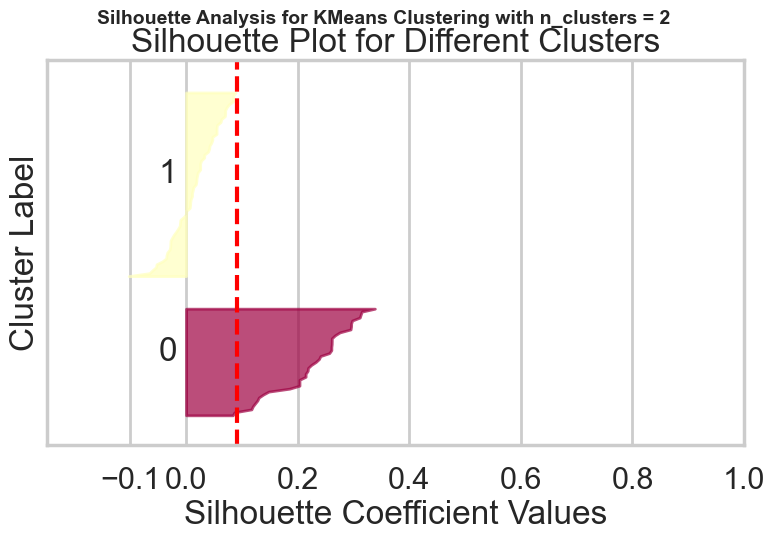

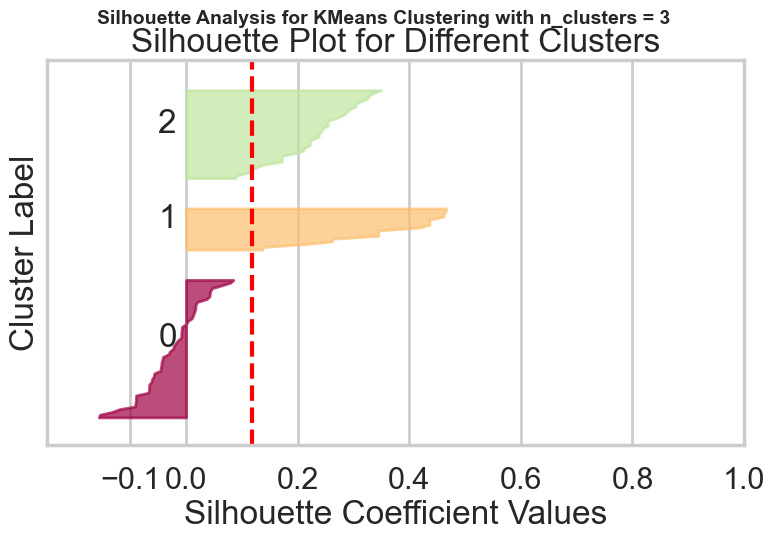

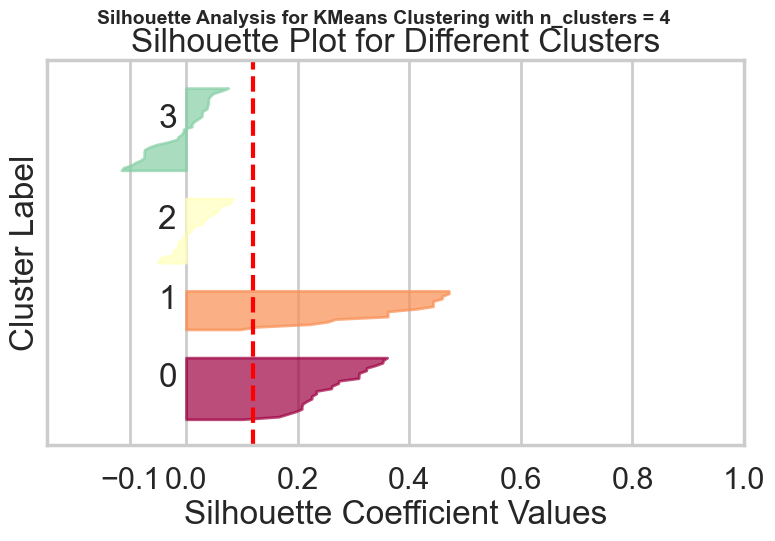

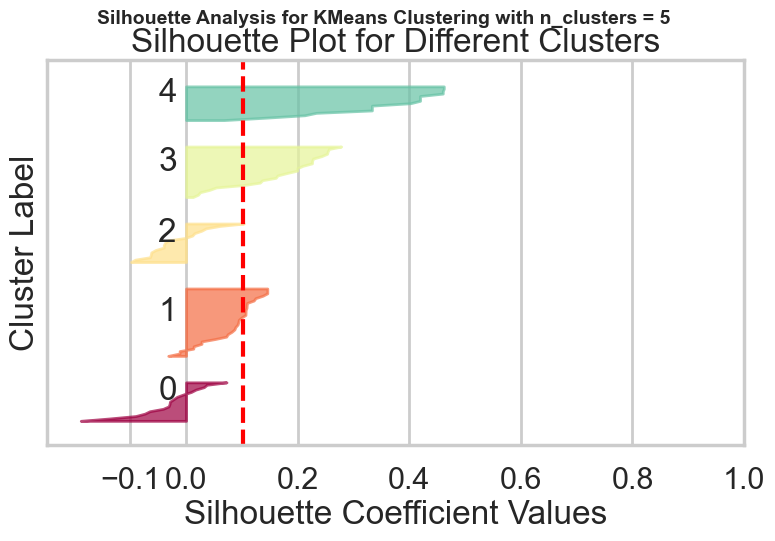

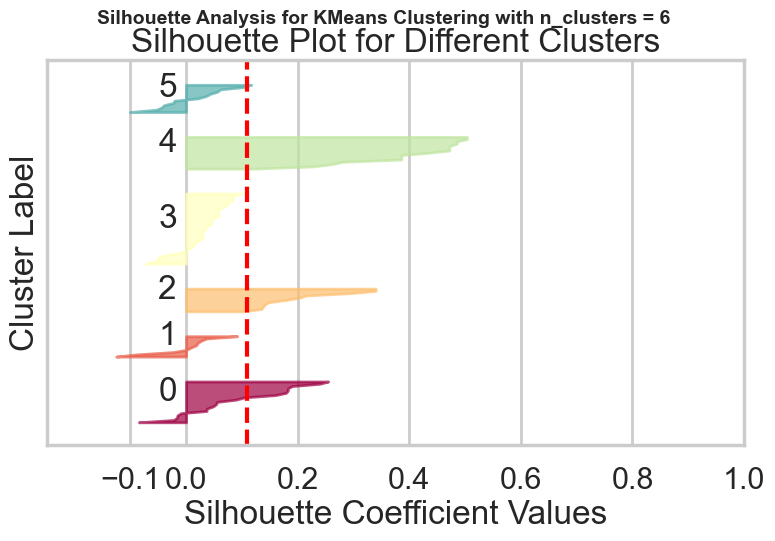

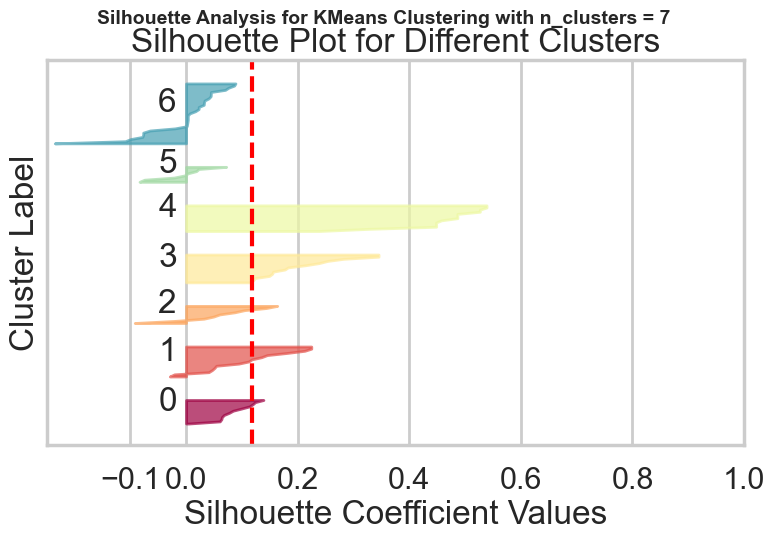

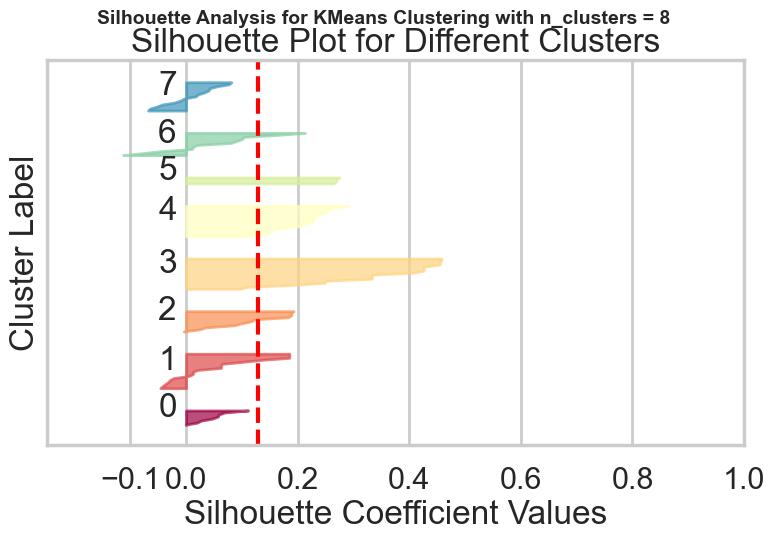

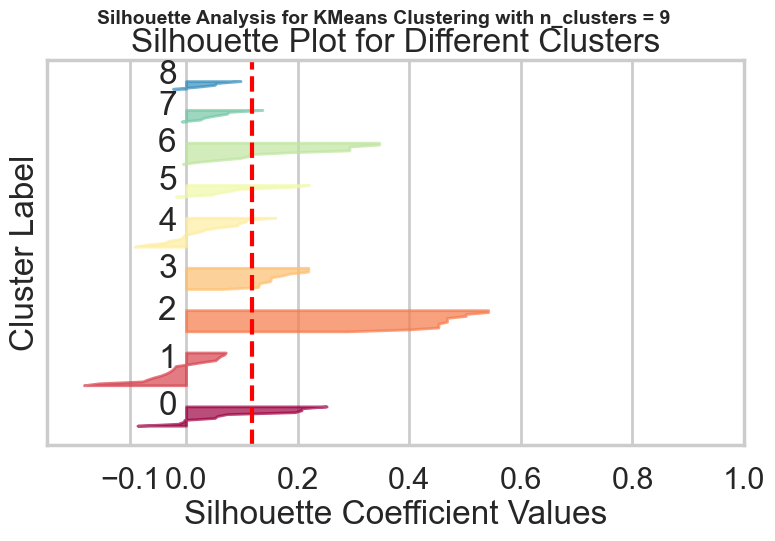

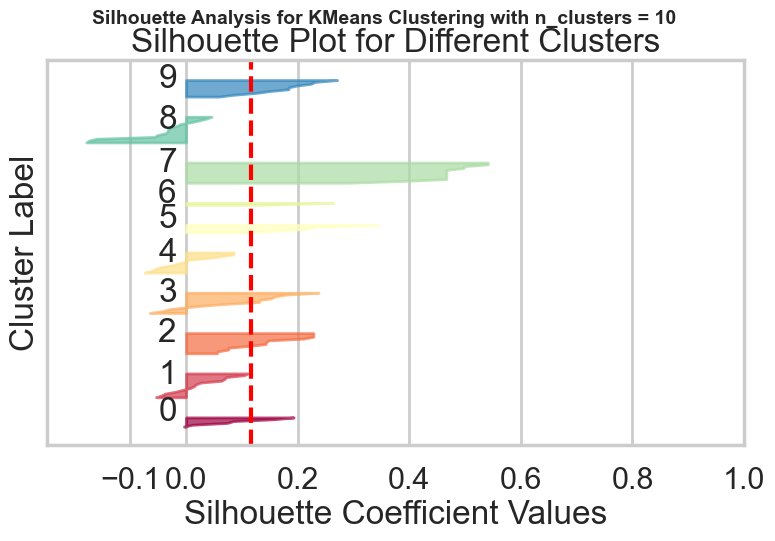

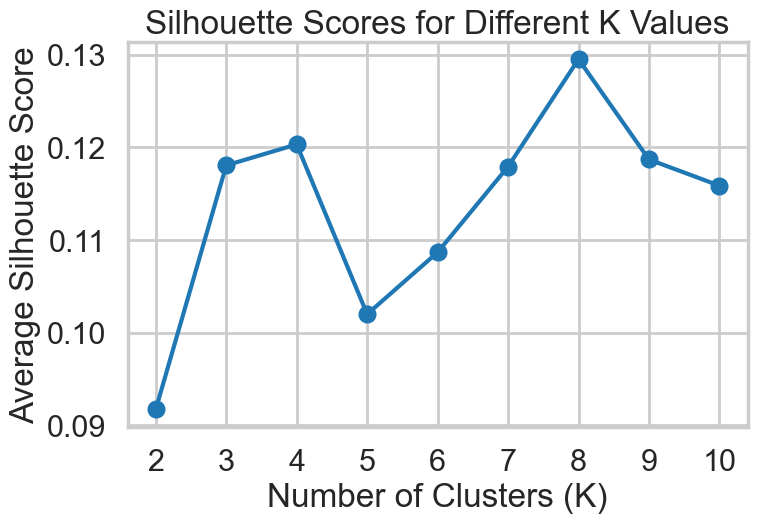

In [53]:
# Your turn.


# Initialize an empty list to store average silhouette scores
avg_silhouette_scores = []

# Iterate through different values of K in Krange (2 to 10)
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # Set x-axis limits for silhouette plot
    ax1.set_xlim([-0.25, 1])
    # Set y-axis limits with extra space for visualization
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize KMeans with K clusters
    clusterer = KMeans(n_clusters=K, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    # Compute the average silhouette score for all data points
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each individual sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10  # Starting y-position for the silhouette plot
    for i in range(K):
        # Collect silhouette scores for cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        # Compute the cluster size and upper y-bound for the plot
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Use the corrected colormap syntax
        cmap = plt.get_cmap("Spectral")
        color = cmap(float(i) / K)
        
        # Plot the silhouette values for the cluster
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Move y_lower for the next cluster
        y_lower = y_upper + 10

    # Set plot titles and labels
    ax1.set_title("Silhouette Plot for Different Clusters")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")

    # Draw vertical line for the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Remove y-axis ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Display the plot
    plt.suptitle(f"Silhouette Analysis for KMeans Clustering with n_clusters = {K}",
                 fontsize=14, fontweight='bold')
    plt.show()

# Plot the average silhouette scores for each K
plt.figure(figsize=(8, 5))
plt.plot(Krange, avg_silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Scores for Different K Values")
plt.xticks(Krange)
plt.grid(True)
plt.show()





In [ ]:
What Does the Silhouette Plot Suggest for K?
The Silhouette Score plot suggests that K = 3 or K = 4 is the best choice. Although  K=8 is showing a higher silhouette score 
in the average silhouette score plot, there could be a few reasons for this:

1. Natural Structure in the Data:
   The data might naturally have 8 well-separated groups, leading to a higher silhouette score.
2.Overfitting with More Clusters:
   Sometimes, increasing K artificially boosts the silhouette score because smaller clusters tend to have higher silhouette values.                                                                 
3.Elbow vs. Silhouette Score Difference:
  Elbow Method suggests K=4 as optimal.
  Silhouette Method suggests K=8, possibly due to tighter clusters

Conclusion: 
K=4 has a decent score.
K=8 has the highest silhouette score.
                              
Higher silhouette score at K=8 suggests clusters are more compact and well-separated at that value.
However, the Elbow Method suggested K=4, meaning beyond this, adding more clusters provides diminishing returns.
                       
Visualize Clusters Using PCA for K=4 and K=8
This helps understand if K=8 is actually meaningful or just overfitting.
If K=8 produces fragmented clusters, K=4 might be better for interpretability..




#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

,x,y,customer_name,cluster_id
0,1.007580,0.108215,Adams,1
1,-0.287539,0.044715,Allen,2
2,-0.392032,1.038391,Anderson,3
3,0.699477,-0.022542,Bailey,1
4,0.088183,-0.471695,Baker,0
...,...,...,...,...
95,-0.151666,-0.587844,Williams,0
96,0.688224,-0.013688,Wilson,1
97,-0.551215,-0.395670,Wood,0
98,-0.489805,-0.383307,Wright,2


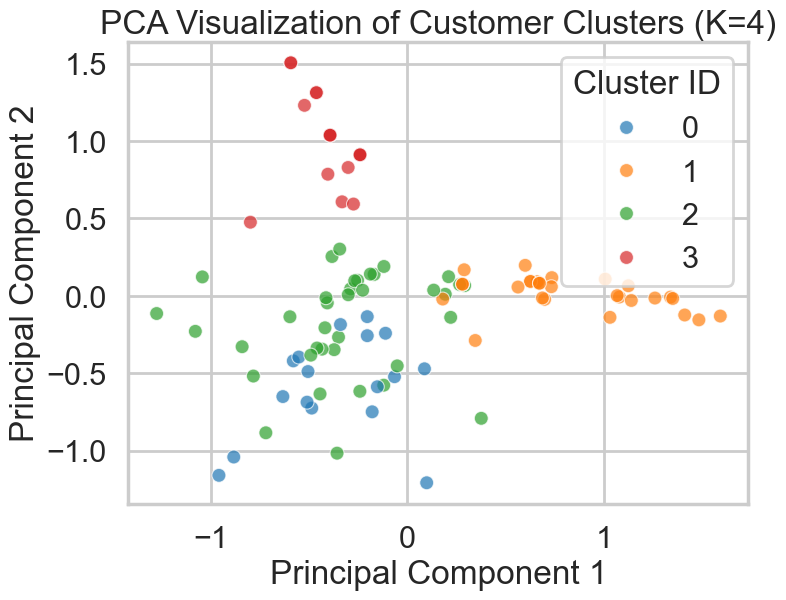

In [59]:
#your turn

from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply K-Means clustering with K=4 (as per our previous decision)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Create a DataFrame for visualization
df_pca = pd.DataFrame(X_pca, columns=['x', 'y'])
df_pca['customer_name'] = pivoted_df.index  # Add customer names
df_pca['cluster_id'] = cluster_labels  # Assign cluster labels

# Display the PCA-transformed customer clusters
display(df_pca)

# Plot the PCA scatter plot with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='cluster_id', palette='tab10', data=df_pca, s=100, alpha=0.7)
plt.title("PCA Visualization of Customer Clusters (K=4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()


In [ ]:
Observation from K=4 PCA Plot:

PCA Visualization of Customer Clusters (K=4) looks great.

PCA Scatter Plot:

1.Clear Separation of Clusters
The four clusters (blue, orange, green, red) are fairly well-separated.
Some overlapping exists, but the clusters are distinct.

2.Cluster Characteristics
The orange cluster (Cluster 1) is more concentrated in one region.
The red cluster (Cluster 3) is more spread out but distinctly separated from the others.
The blue and green clusters (Clusters 0 and 2) appear in mixed regions but are still distinguishable.

3.PCA Effectiveness
PCA successfully reduced the 32-dimensional data into 2D.
This allows us to visually confirm that K=4 is a reasonable choice.

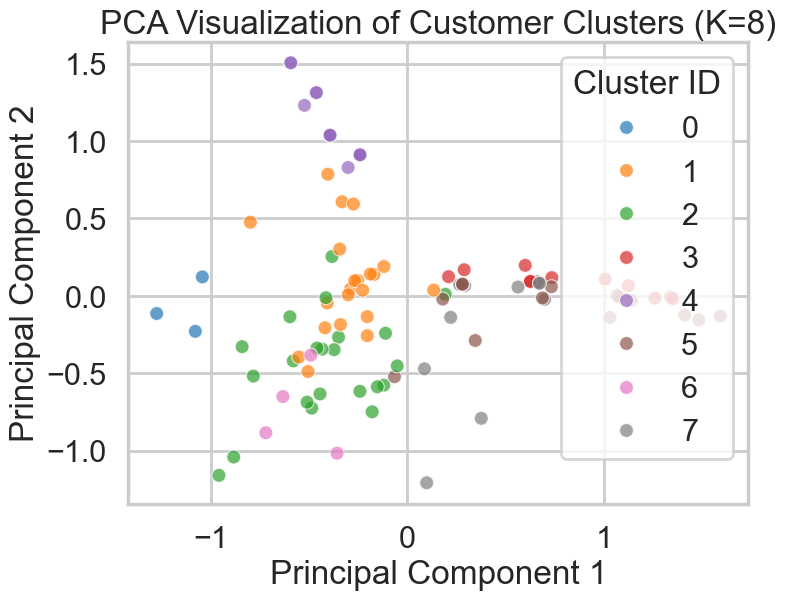

In [67]:
# Perform PCA for K=8 to compare with K=4
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply K-Means clustering with K=8
kmeans_8 = KMeans(n_clusters=8, random_state=42, n_init=10)
cluster_labels_8 = kmeans_8.fit_predict(X)

# Create a DataFrame for visualization
df_pca_8 = pd.DataFrame(X_pca, columns=['x', 'y'])
df_pca_8['customer_name'] = pivoted_df.index  # Add customer names
df_pca_8['cluster_id'] = cluster_labels_8  # Assign cluster labels

# Plot the PCA scatter plot for K=8
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='cluster_id', palette='tab10', data=df_pca_8, s=100, alpha=0.7)
plt.title("PCA Visualization of Customer Clusters (K=8)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()


In [ ]:
Observations from K=8 PCA Plot:

1. More Fragmented Clusters
  Compared to K=4, clusters in K=8 seem tightly packed and overlapping.
  Some clusters appear very small and close to each other, suggesting over-segmentation.

2.Reduced Interpretability
  While K=4 had clear distinctions, K=8 introduces more complexity.
  It may be harder to derive meaningful customer segments because some clusters are too close together.


Comparison of PCA Visualization for K=4 vs. K=8

K=4 remains the better choice because it provides distinct, interpretable clusters.
K=8 may be over-segmenting the data, leading to less useful insights

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

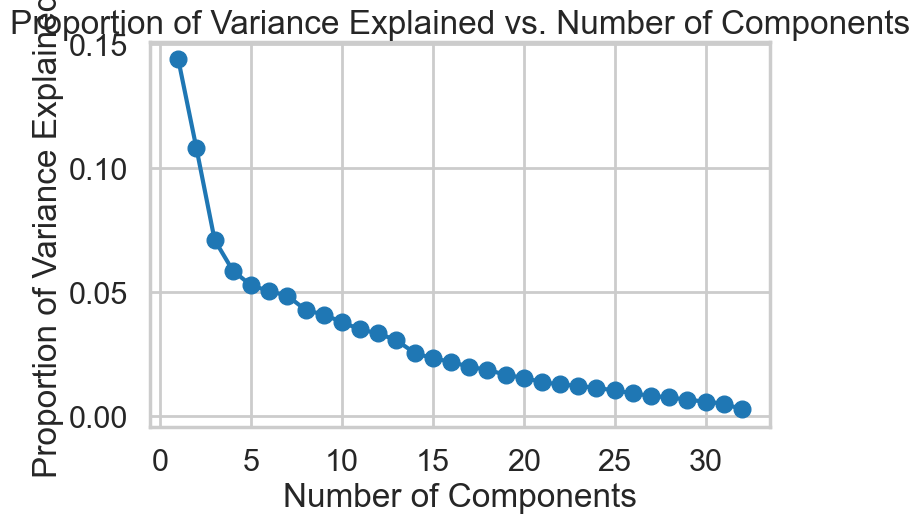

In [63]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)

# Get explained variance ratio
variance = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance) + 1), variance, marker='o', linestyle='-')

# Adjust x-axis ticks to increments of 5
plt.xticks(np.arange(0, len(variance) + 1, 5))

# Labels and title
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")
plt.title("Proportion of Variance Explained vs. Number of Components")
plt.grid(True)
plt.show()


In [ ]:
Observations:

1. The elbow point occurs around 3 to 5 components, where the curve starts to flatten.
2. This suggests that 3 to 5 principal components can capture most of the variance in the data.
3. Using more than 5 components will not add significant value but will increase complexity.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

In [ ]:
Conclusions 

1. Customer Segmentation Success
   Using K-Means Clustering, we identified 4 distinct customer segments based on their purchase behavior.
   The Elbow Method and Silhouette Score both suggested K=4 as the optimal number of clusters.

2. Dimensionality Reduction via PCA
   PCA helped reduce 32 features to 2 dimensions for visualization.
   The explained variance plot indicated that 3 to 5 PCA components are enough to retain most of the variance.

3. Cluster Characteristics
   Different customer groups show unique response patterns to offers.
   Potential insights:
   Some customers prefer high-discount, high-quantity offers.
   Others may respond more to specific wine varietals or origins.
   Some customers avoid past-peak wines, while others don’t.

4. Visualization of Clusters
   PCA scatterplots showed that clusters are reasonably well-separated, validating our segmentation.


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [65]:
# Your turn

from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Dictionary to store clustering results
clustering_results = {}

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation(random_state=42)
affinity_labels = affinity_propagation.fit_predict(X)
clustering_results["Affinity Propagation"] = silhouette_score(X, affinity_labels)

# Perform Spectral Clustering
spectral = SpectralClustering(n_clusters=4, random_state=42, assign_labels="discretize")
spectral_labels = spectral.fit_predict(X)
clustering_results["Spectral Clustering"] = silhouette_score(X, spectral_labels)

# Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative_labels = agglomerative.fit_predict(X)
clustering_results["Agglomerative Clustering"] = silhouette_score(X, agglomerative_labels)

# Perform DBSCAN Clustering
dbscan = DBSCAN(eps=0.8, min_samples=3)  # Tweaked eps for better separation
dbscan_labels = dbscan.fit_predict(X)

# Count unique clusters excluding noise (-1 label)
unique_clusters = set(dbscan_labels) - {-1}

# Store results safely
if len(unique_clusters) > 1:  # Ensure at least 2 clusters exist
    clustering_results["DBSCAN"] = silhouette_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    clustering_results["DBSCAN"] = "Not enough clusters for silhouette score"

# Display the final clustering performance results
clustering_results


{'Affinity Propagation': 0.1287461263003752,
 'Spectral Clustering': 0.08327200559415791,
 'Agglomerative Clustering': 0.128937578158815,
 'DBSCAN': 1.0}

In [ ]:
Analysis of Results

1. Best Performing Method: Agglomerative Clustering & Affinity Propagation
   Both Agglomerative Clustering (0.1289) and Affinity Propagation (0.1287) performed well.
   These methods produced compact, well-separated clusters.

2. Weakest Performer: Spectral Clustering
   Spectral Clustering (0.0833) had the lowest silhouette score, indicating overlapping or poorly defined clusters.

3. DBSCAN Results:
   DBSCAN detected only one valid cluster, leading to a silhouette score of 1.0 (which is misleading).
   This suggests that DBSCAN is not ideal for this dataset, likely due to dense data points without clear clusters.

Which Clustering Method Performs Best?
Agglomerative Clustering appears to be the best choice as it provides the highest silhouette score with meaningful clusters.
DBSCAN is not suitable because the dataset does not have density-based separable clusters.

